In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append("../..")

Submit: https://www.kaggle.com/c/dog-breed-identification/submissions?sortBy=date&group=all&page=1

In [3]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

/home/shmuma/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
PATH = "../../courses/dl1/data/dogs-breed/"

In [5]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv))) - 1 # header is not counted (-1)
val_idxs = get_cv_idxs(n) # random 20% data for validation set

Weights got from http://files.fast.ai/models/weights.tgz

In [6]:
sz = 224

In [19]:
def get_data(sz, bs, arch=resnet50):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, "train", f"{PATH}/labels.csv", bs=bs, \
                                        test_name="test", tfms=tfms, suffix='.jpg', val_idxs=val_idxs)
    if sz > 300:
        return data
    else:
        return data.resize(sz, 'tmp')

In [8]:
data = get_data(sz, 64)

In [17]:
learn = ConvLearner.pretrained(arch, data, precompute=False)

In [10]:
lrf = learn.lr_find()

 95%|█████████▍| 121/128 [00:44<00:02,  2.69it/s, loss=8.15]

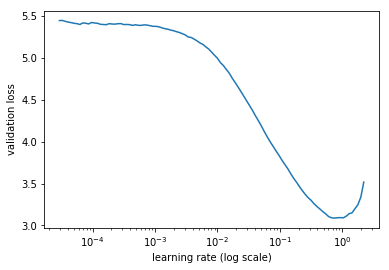

In [12]:
learn.sched.plot()

In [13]:
learn.fit(1e-1, 5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.075066   0.537391   0.832681  
    1      0.771289   0.48884    0.843444                    
    2      0.6436     0.490562   0.851272                    
    3      0.587176   0.476547   0.849315                    
    4      0.528012   0.497397   0.850783                    


[array([0.4974]), 0.850782779098257]

In [16]:
# from initial state, to verify effect of smaller LR
# conclusion: 1e-1 is better, try to use cycle_mult=2
learn.fit(1e-2, 5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.811856   1.070986   0.790607  
    1      1.065792   0.671454   0.828278                   
    2      0.824576   0.563782   0.84589                     
    3      0.710412   0.513693   0.848826                    
    4      0.607209   0.49171    0.842955                    


[array([0.49171]), 0.8429549907984799]

In [18]:
# from initial state, to verify effect of cycle_mult=2
learn.fit(1e-1, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.09431    0.536021   0.832681  
    1      0.849616   0.559319   0.824853                    
    2      0.550363   0.48377    0.848826                    
    3      0.642154   0.597984   0.818493                    
    4      0.542045   0.508471   0.843933                    
    5      0.403467   0.480939   0.858611                    
    6      0.333757   0.478736   0.8591                      


[array([0.47874]), 0.8590998036054249]

In [20]:
learn.set_data(get_data(299, 64))

In [21]:
learn.fit(1e-1, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.378861   0.439839   0.869374  
    1      0.398901   0.470188   0.863503                    
    2      0.312521   0.444903   0.873288                    
    3      0.374004   0.496006   0.866438                    
    4      0.333982   0.48725    0.864481                    
    5      0.274233   0.455805   0.867906                    
    6      0.212601   0.453106   0.870841                    


[array([0.45311]), 0.870841486929914]

In [29]:
def produce_output(learn, out_fname):
    log_probs = learn.predict(True)
    probs = np.exp(log_probs)
    res_pd = pd.DataFrame(probs)
    res_pd.columns = learn.data.classes
    res_pd['id'] = list(map(lambda n: os.path.basename(n)[:-4], learn.data.test_ds.fnames))
    res_pd = res_pd.set_index('id')
    res_pd.to_csv(out_fname, compression='gzip')
    return FileLink(out_fname)

# Larger model

In [22]:
data = get_data(229, 64, arch=resnet101)
learn2 = ConvLearner.pretrained(resnet101, data, precompute=False)

 95%|█████████▌| 122/128 [00:29<00:01,  4.20it/s, loss=10.6]

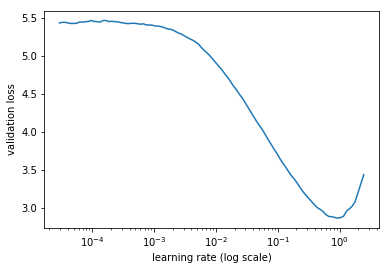

In [23]:
learn2.lr_find()
learn2.sched.plot()

In [24]:
learn2.fit(1e-1, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.937021   0.467772   0.857632  
    1      0.725454   0.454247   0.84589                     
    2      0.475787   0.396947   0.873777                    
    3      0.552412   0.478286   0.858611                    
    4      0.458209   0.424179   0.866438                    
    5      0.344687   0.382045   0.887965                    
    6      0.292635   0.376012   0.883562                    


[array([0.37601]), 0.8835616439522596]

In [26]:
learn2.set_data(get_data(299, 64, arch=resnet101))

In [27]:
learn2.fit(1e-1, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.313732   0.362394   0.890411  
    1      0.318908   0.406949   0.890411                    
    2      0.247904   0.360867   0.894814                    
    3      0.340379   0.387552   0.8909                      
    4      0.2853     0.400921   0.888943                    
    5      0.202938   0.362641   0.899706                    
    6      0.185909   0.35407    0.901663                    


[array([0.35407]), 0.9016634056712783]

In [28]:
learn2.fit(1e-1, 5, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.211001   0.3785     0.896771  
    1      0.225251   0.410973   0.8909                      
    2      0.181556   0.384446   0.894814                    
    3      0.205213   0.455182   0.883562                    
    6      0.13261    0.390883   0.895303                    
    7      0.224675   0.442479   0.885519                    
    8      0.206314   0.462065   0.885029                    
    9      0.183965   0.412216   0.895793                    
    10     0.157826   0.404661   0.893836                    
    11     0.130643   0.40274    0.894814                    
    12     0.109394   0.399586   0.899217                    
    13     0.103177   0.39456    0.895303                     
    14     0.099074   0.394573   0.89775                      
    15     0.168468   0.459904   0.887965                    
    16     0.202027   0.460138   0.890411                    
    17     0.174808   0.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [31]:
produce_output(learn2, "res-b2-1.csv.gz")

/home/shmuma/work/classes/classes-repo.git/fast.ai/fastai/my/dogsbreeds/res-b2-1.csv.gz

Score is 0.4419, much worse than previous versions